# Proyecto Final de Estadística

### Autor: Leonardo Bravo


En el proyecto de tesis se está trabajando sobre curvas de luz de objetos astronómicos que simulan mediciones que realizará telescopio LSST (Dataset denominado PLASTICC: https://zenodo.org/record/2539456 ). El objetivo de la tesis es generar representaciones de las curvas de luz en variables latentes utilizando modelos de deep learning. Una de las formas de validar la utilidad de las variables latentes, corresponde a la utilización de estas variables para clasificación supervisada. Para verificar utilidad de variables latentes generadas, se compararán con features que ya se utilizan para curvas de luz (existe amplia literatura sobre ellas). 

Considerando lo anterior, para el proyecto de estadística, se realizan las siguientes actividades:

- Obtención de features desde las curvas de luz (PLASTICC) utilizando features que ya están definidas y ampliamente estudiadas. Para esto se utiliza librería FATS (https://github.com/carpyncho/feets), la cual permite obtener un serie de features a partir de una curva de luz. Las features calculadas corresponden a diversos descriptores (desde estadísticos (tales como la varianza), hasta funciones complejas (tales como función de autocorrelación)).


- Luego de obtenidas las features, se obtienen variables latentes, utilizando PCA y Autoencoder.


-  Sobre el espacio latente, se realiza clasificación supervisada, utilizando regresor logítisco.


El objetivo es explorar diferentes dimensiones de las variables latentes y analizar cuales generan mejores resultados sobre la clasificación (comparando métricas, tales como accuracy y F1 Score).


# Load libraries

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

# Load data

Se utiliza un subconjunto del dataset original (para simplificar análisis, ya que el dataset es pesado (1GB cada subconjunto, teniendose 11 subconjuntos en total)).

El dataset original contiene 10.855.958 observaciones distribuidos en 18 clases diferentes. Se tiene la variable "object_id", la cual corresponde al id de un objeto astronómico. Agrupando las observaciones por "object_id", se puede obtener la curva de luz para ese objeto. 

Acá esta el código con el cual se obtuvieron los datos para aplicar cálculo de features, sin embargo, el dataset utilizado finalmente, corresponde a un subconjunto del dataset que se carga en el siguiente código. Las razones se explican mas adelante.

In [2]:
# import data

path = "../../../../thesis/work/plasticc_dataset/"

# Train data
# train = pd.read_csv(path + "training_set.csv")
# train = pd.read_csv(path + "plasticc_train_lightcurves.csv")
# # print("Training data set")
# # display(train.head())

# metadata
# metadata_train = pd.read_csv(path + "training_set_metadata.csv")
# metadata_train = pd.read_csv(path + "plasticc_train_metadata.csv")
# # print("Metadata for training dataset")
# # display(metadata_train.head())

# # Test data
test1 = pd.read_csv(path + "plasticc_test_set_batch1.csv")
# test2 = pd.read_csv(path + "plasticc_test_set_batch2.csv")
# print("Test data set: ", test.shape)
# display(test.head())

# test metadata
metadata_test = pd.read_csv(path + "plasticc_test_metadata.csv")
# # print("Metadata for test dataset: ", metadata_test.shape)
# # display(metadata_test.head())

# # merge data
# merged_data_train = train.merge(metadata_train, on = "object_id")
merged_data_test1 = test1.merge(metadata_test, on = "object_id")
# merged_data_test2 = test2.merge(metadata_test, on = "object_id")
# merged_data = merged_data_train.merge(merged_data_test, on = "object_id")
# data = pd.concat([merged_data_train, merged_data_test])
# print("train merged data")
# display(merged_data_train.head())

# print("test merged data")
# display(merged_data_test.head())

# print("test merged data")
# display(merged_data_test.head())
# # # display(merged_data_test.head())
# # merged_data_test["object_id"].hist()
# # merged_data_train["object_id"].hist()
# # display(merged_data.head())

# # print("train data: ", merged_data_train.shape)
# print("test data: ", merged_data_test.shape)

In [3]:
# data = pd.concat([merged_data_train, merged_data_test])
print("Shape of data to work: ", merged_data_test1.shape)
# print(merged_data_train.shape)
# print(merged_data_test2.shape)
print("Unique targets: ", merged_data_test1.true_target.unique().shape[0])
print("targets: ", merged_data_test1.true_target.unique())

Shape of data to work:  (10855958, 31)
Unique targets:  18
targets:  [ 42  90  16  67  62 993  92  52  88  65 991 992  15  95   6  53 994  64]


### Ploteando una curva de luz
Para ayudar a comprender el dataset, se plotea una curva de luz de un objeto astronómico. En este gráfico se plotea la variable "mjd" (corresponde al tiempo (fecha) en el que se realizó la medición) en función de la variable "flux" (la que corresponde al brillo del objeto).

In [ ]:
#print list of ids
print("Se tienen ", merged_data_test1.object_id.unique(), " objetos astronómicos diferentes")

# get one light curve
one_ligth_curve = merged_data_test1[merged_data["object_id"] == 713]

#display(one_ligth_curve)
#plot light curve
fix, ax = plt.subplots()
ax.scatter(one_ligth_curve["mjd"], one_ligth_curve["flux"])

## Seleccción de data a utilizar para analisis

Debido a que dataset utilizado esta desbalanceado (análisis realizados), se decide utilizar subconjunto de datos originales, quedándose finalmente con 4 clases. Estas clases poseen menos de 1 MM y mas de 100 mil observaciones diferentes. Estas 4 clases se encuentran mas balanceadas que las otras clases del dataset.

In [4]:
# amount = merged_data_test1_filter.groupby("true_target").count()
amount = merged_data_test1.groupby("true_target").count()
display(amount.sort_values(by=['object_id'], ascending = False))
# display(amount)
# amount.index

# choose for remove classes
removing_classes = False
if removing_classes:
    
    classes_to_remove = [42, 90, 62]
    amount = amount.drop(classes_to_remove)
    
else:
    
    # > 1MM
#     classes_to_analyze = [42, 90]
    # < 1MM and > 100K
    classes_to_analyze = [62, 52, 88, 67]
#     # < 100k and > 10k
#     classes_to_analyze = [993, 92, 95, 15, 65, 992]
    # < 10k and > 0
#     classes_to_analyze = [991, 994, 53, 6, 16, 64]
#     993 until last one
#     classes_to_analyze = [x for x in merged_data_test1["true_target"].unique() if x not in [42, 90, 62, 52, 88, 67]]
    amount = amount.loc[classes_to_analyze, :]
    

display(amount)

,object_id,mjd,passband,flux,flux_err,detected_bool,ra,decl,ddf_bool,hostgal_specz,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
true_target,,,,,,,,,,,,,,,,,,,,,
42,5288846,5288846,5288846,5288846,5288846,5288846,5288846,5288846,5288846,5288846,...,5288846,5288846,5288846,5288846,5288846,5288846,5288846,5288846,5288846,5288846
90,4152048,4152048,4152048,4152048,4152048,4152048,4152048,4152048,4152048,4152048,...,4152048,4152048,4152048,4152048,4152048,4152048,4152048,4152048,4152048,4152048
62,722642,722642,722642,722642,722642,722642,722642,722642,722642,722642,...,722642,722642,722642,722642,722642,722642,722642,722642,722642,722642
52,267001,267001,267001,267001,267001,267001,267001,267001,267001,267001,...,267001,267001,267001,267001,267001,267001,267001,267001,267001,267001
88,118433,118433,118433,118433,118433,118433,118433,118433,118433,118433,...,118433,118433,118433,118433,118433,118433,118433,118433,118433,118433
67,118042,118042,118042,118042,118042,118042,118042,118042,118042,118042,...,118042,118042,118042,118042,118042,118042,118042,118042,118042,118042
993,47089,47089,47089,47089,47089,47089,47089,47089,47089,47089,...,47089,47089,47089,47089,47089,47089,47089,47089,47089,47089
92,45886,45886,45886,45886,45886,45886,45886,45886,45886,45886,...,45886,45886,45886,45886,45886,45886,45886,45886,45886,45886
95,32081,32081,32081,32081,32081,32081,32081,32081,32081,32081,...,32081,32081,32081,32081,32081,32081,32081,32081,32081,32081


,object_id,mjd,passband,flux,flux_err,detected_bool,ra,decl,ddf_bool,hostgal_specz,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
true_target,,,,,,,,,,,,,,,,,,,,,
62,722642,722642,722642,722642,722642,722642,722642,722642,722642,722642,...,722642,722642,722642,722642,722642,722642,722642,722642,722642,722642
52,267001,267001,267001,267001,267001,267001,267001,267001,267001,267001,...,267001,267001,267001,267001,267001,267001,267001,267001,267001,267001
88,118433,118433,118433,118433,118433,118433,118433,118433,118433,118433,...,118433,118433,118433,118433,118433,118433,118433,118433,118433,118433
67,118042,118042,118042,118042,118042,118042,118042,118042,118042,118042,...,118042,118042,118042,118042,118042,118042,118042,118042,118042,118042


([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

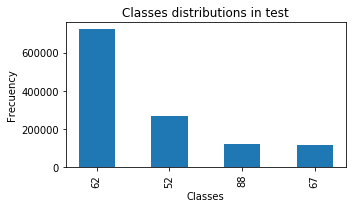

In [5]:
# plotting classes
# fig, ax = plt.subplots(1, 2, figsize = (10, 3), tight_layout = True)
fig, ax = plt.subplots(figsize = (5, 3), tight_layout = True)
# ax = fig.add_axes([0,0,1,1])
# plt.bar(objects_per_target.index, objects_per_target)
# ax[0].hist(merged_data_train.loc[:, "target"], density = True)
# ax[0].set_xlabel("Classes")
# ax[0].set_ylabel("Frecuency")
# ax[0].set_title("Classes distributions in train")

# # ax[1].hist(merged_data_test1.true_target, bins = 18)
# ax[1].bar([str(x) for x in  amount.index.tolist()], amount.object_id.values, width = 1)
# # ax[1].hist(merged_data_test1_filter.true_target, bins = 14)
# ax[1].set_xlabel("Classes")
# ax[1].set_ylabel("Frecuency")
# ax[1].set_title("Classes distributions in test")
# # ax[1].hist(merged_data_test.loc[:, "target"])
# plt.xticks(rotation=90)

# ax[1].hist(merged_data_test1.true_target, bins = 18)
ax.bar([str(x) for x in  amount.index.tolist()], amount.object_id.values, width = 0.5, align = "center")
# ax[1].hist(merged_data_test1_filter.true_target, bins = 14)
ax.set_xlabel("Classes")
ax.set_ylabel("Frecuency")
ax.set_title("Classes distributions in test")
# ax[1].hist(merged_data_test.loc[:, "target"])
plt.xticks(rotation=90)

# objects_per_target_train = merged_data_train.groupby("target", )["object_id"].count()
# display(objects_per_target)
# # fig, ax = plt.subplots(1, 2)
# # # ax = fig.add_axes([0,0,1,1])
# ax[0].bar(objects_per_target.index, objects_per_target)
# # ax[0].hist(merged_data_train["object_id"])

Del histograma anterior, se tiene las clases escogidas estan desbalanceadas, sin embargo, dentro de las clases analizadas, este grupo es el que mas caracter de balance tiene.

# Change name of dataset for simplicity

In [6]:
# light_curves = merged_data_train
# light_curves = merged_data_test1_filter
light_curves = merged_data_test1
# light_curves = merged_data_train[(merged_data_train["object_id"] == 615)]

print("data shape: ", light_curves.shape)
# print("data columns: ", light_curves.columns)
print("original objects ids: ", light_curves.object_id.unique().shape)
print("original classes: ", light_curves.true_target.unique().shape)

# getting only useful features
light_curves_ = light_curves[["object_id", "mjd", "passband", "flux", "flux_err", "true_target"]]
light_curves_ = light_curves_.rename(columns={"true_target": "target"})
# ligth_curves_.head()

light_curves = light_curves_
print("original classes: ", light_curves_.target.unique())

# Taking a subgroup of classes
if removing_classes:
    # get classes to analyze removing classes_to_remove
    light_curves = light_curves.loc[light_curves["target"].isin([x for x in light_curves["target"].unique() if x not in classes_to_remove])]
else:
    # for take only a part of classes and remove anothers ones
    light_curves = light_curves.loc[light_curves["target"].isin(classes_to_analyze)]
      
print("Final shape dataset to analyze: ", light_curves.shape)
print("Final classes: ", light_curves.target.unique().shape)
print("Total objects: ", light_curves.object_id.unique().shape)
print("final classes: ", light_curves.target.unique())

data shape:  (10855958, 31)
original objects ids:  (32926,)
original classes:  (18,)
original classes:  [ 42  90  16  67  62 993  92  52  88  65 991 992  15  95   6  53 994  64]
Final shape dataset to analyze:  (1226118, 6)
Final classes:  (4,)
Total objects:  (3726,)
final classes:  [67 62 52 88]


Finalmente, dataset a analizar:

- 4 clases a analizar.
- 3.726 objetos astronómicos diferentes (3.726 curvas de luz o series de tiempo).

# Feature extraction

Se extraen features desde cada una de las curvas de luz. Para esto se utiliza librería FATS (https://github.com/carpyncho/feets), la cual permite obtener un serie de features a partir de una curva de luz. Las features calculadas corresponden a diversos descriptores (desde estadísticos (tales como la varianza), hasta funciones complejas (tales como función de autocorrelación)).

Para simplificar análisis, se analiza únicamente 1 canal de la serie de tiempo (poseen 6 canales). Dada esta simplificación, las features que se calculan son listadas en la lista "features_names".

### Select features

In [7]:
# get all object_ids
object_ids = light_curves["object_id"].unique()

print("There are " + str(object_ids.shape[0]) + " differentes objects, classified in "+ str(light_curves["target"].unique().shape[0]) + " differentes classes")
print(type(object_ids))

# overwrite objects ids (it's for analyze a piece of total objects's)
# objects_ids_to_analyze = object_ids.shape[0]
objects_ids_to_analyze = int(object_ids.shape[0])
# objects_ids_to_analyze = 1000
print("objects to analyze: ", objects_ids_to_analyze)
idx = np.random.randint(object_ids.shape[0], size=objects_ids_to_analyze)
object_ids = object_ids[idx]
# object_ids = object_ids[0:objects_ids_to_analyze]
# print(object_ids)

# set passband to analyze
passband = 0

features_names = ['Amplitude',
                  'AndersonDarling', 
                  'Autocor_length', 
                  'Beyond1Std', 
                  'CAR_mean',
                  'CAR_sigma', 
                  'CAR_tau', 
                  'Con', 
                  'Eta_e', 
                  'FluxPercentileRatioMid20',
                 'FluxPercentileRatioMid35', 
                  'FluxPercentileRatioMid50',
                 'FluxPercentileRatioMid65' ,
                  'FluxPercentileRatioMid80',
                 'Freq1_harmonics_amplitude_0' ,
                  'Freq1_harmonics_amplitude_1',
                 'Freq1_harmonics_amplitude_2' ,
                  'Freq1_harmonics_amplitude_3',
                 'Freq1_harmonics_rel_phase_0' ,
                  'Freq1_harmonics_rel_phase_1',
                 'Freq1_harmonics_rel_phase_2' ,
                  'Freq1_harmonics_rel_phase_3',
                 'Freq2_harmonics_amplitude_0' ,
                  'Freq2_harmonics_amplitude_1',
                 'Freq2_harmonics_amplitude_2' ,
                  'Freq2_harmonics_amplitude_3',
                 'Freq2_harmonics_rel_phase_0' ,
                  'Freq2_harmonics_rel_phase_1',
                 'Freq2_harmonics_rel_phase_2' ,
                  'Freq2_harmonics_rel_phase_3',
                 'Freq3_harmonics_amplitude_0' ,
                  'Freq3_harmonics_amplitude_1',
                 'Freq3_harmonics_amplitude_2' ,
                  'Freq3_harmonics_amplitude_3',
                 'Freq3_harmonics_rel_phase_0' ,
                  'Freq3_harmonics_rel_phase_1',
                 'Freq3_harmonics_rel_phase_2' ,
                  'Freq3_harmonics_rel_phase_3' ,
                  'Gskew',
                 'LinearTrend',
                  'MaxSlope', 
                  'Mean', 
                  'Meanvariance', 
                  'MedianAbsDev', 
                  'MedianBRP',
                 'PairSlopeTrend', 
                  'PercentAmplitude',
                  'PercentDifferenceFluxPercentile',
                 'PeriodLS',
                  'Period_fit',
                  'Psi_CS', 
                  'Psi_eta' ,
                  'Q31', 
                  'Rcs', 
                  'Skew',
                 'SlottedA_length',
                  'SmallKurtosis',
                  'Std',
                  'StetsonK' ,
                  'StetsonK_AC',
                 'StructureFunction_index_21',
                  'StructureFunction_index_31',
                 'StructureFunction_index_32'
                 ]

# # Getting one ligth curve for get ist features names
# mask1 = light_curves["object_id"] == 615
# mask2 = light_curves["passband"] == passband
# lc = light_curves[(mask1 & mask2)]

# # array with required data
# lc_data = [lc.mjd, lc.flux, lc.flux_err]

# # getting features
# fs = feets.FeatureSpace(data = ["time", "magnitude", "error"])
# # get features names
# features, values = fs.extract(*lc_data)
# features_names = features
# print(features_names)

There are 3726 differentes objects, classified in 4 differentes classes
<class 'numpy.ndarray'>
objects to analyze:  3726


### Compute features

En el siguiente código, se calculan las features utilizando librería. Las features se calculan para objeto astrónimco.

In [152]:
from tqdm import tqdm_notebook
import feets.preprocess

# # select features
# # from 0:10 and remove AndersonDarling and FluxPercentileRatioMid20 it have an error: AttributeError: 'int' object has no attribute 'keys'
# features_names = features_names[0:5].tolist()
# features_names.remove("AndersonDarling")
# # features_names.remove("FluxPercentileRatioMid20")
# print((features_names))

print("features to get: ", features_names)

# array of features values
features_values = np.zeros((len(object_ids), len(features_names)))

# array of targets (classes)
targets = np.zeros(len(object_ids))

# iterate through each object id
for index, object_id in enumerate(tqdm_notebook(object_ids)):
    print("object id: ", object_id)
    
    # Getting each ligth curve
    mask1 = light_curves["object_id"] == object_id
    mask2 = light_curves["passband"] == passband
    lc = light_curves[(mask1 & mask2)]
    
    # array with required data
    lc_data = [lc.mjd, lc.flux, lc.flux_err]
    
#     # preprocessing
#     time, mag, error = feets.preprocess.remove_noise(time = lc.mjd, magnitude = lc.flux, error = lc.flux_err)
    
    # feature extraction
    fs = feets.FeatureSpace(only = features_names, data = ["time", "magnitude", "error"])
#     # get all features it can obteins with available data (parameter) 
#     fs = feets.FeatureSpace(data = ["time", "magnitude", "error"])
    features, values = fs.extract(*lc_data)
    
    # add features to features values arrays
    features_values[index, :] = values
    
    # get target of object
    targets[index] = lc.iloc[0, -1]
#     print(features.shape)
    
#     print(values)
#     print(index)

features to get:  ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std', 'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e', 'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_0', 'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2', 'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2', 'Freq3_harmo

object id:  289877
object id:  156731


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  93049
object id:  161224
object id:  298226
object id:  81319


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  253649
object id:  107780
object id:  231522
object id:  4025


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  45395
object id:  168


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  329636


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=

object id:  330535
object id:  298226


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  331894
object id:  253649


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  72907
object id:  63782


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


object id:  161224


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  149344
object id:  230192


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=

object id:  112314
object id:  259823
object id:  107780


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  161224


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  268222
object id:  253649


/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  80421
object id:  63782
object id:  268222


/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but the result is ~0.2
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of AndersonDarling must be ~0.25 for gausian distribution but the  result is ~-0.60
  warnings.warn(w, ExtractorWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/feets/extractors/core.py:234: ExtractorWarning: The original FATS documentation says that the result of StetsonK must be 2/pi=0.798 for gausian distribution but th

object id:  112314



/home/leo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


### Build dataframe from computed features

Debido a que proceso de cálculo de features es extenso en tiempo, cada vez que se analizaban diferentes combinaciones de clases (para analizar desbalance), se almacenaban las features obtenidas en un nuevo dataset.

In [8]:
# concatenate the feautres and targets of objects
features_values_with_targets = np.c_[ features_values, targets ]
# print(features_values_with_targets.shape)

# add target to name (for columns names)
columns = features_names + ["target"]
# print(columns)

# create new dataframe
features_light_curves = pd.DataFrame(data = features_values_with_targets,    # values
                                      index = object_ids,    # 1st column as index
                                      columns = columns
                                    )

# display new dataframe
display(features_light_curves.head())
print("features light curves shape: ",features_light_curves.shape )
print("Differens objects ids: "+ str(features_light_curves.shape[0]))
display(features_light_curves.describe())
display(features_light_curves["target"].unique().shape)
display(features_light_curves["target"].unique())

NameError: name 'features_values' is not defined

In [9]:
# checking if it contains nan values
features_light_curves = features_light_curves.dropna()
print("Missing values: ", features_light_curves.isnull().sum().sum())

NameError: name 'features_light_curves' is not defined

# Saving features light curves dataset in file

In [156]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

# store dataframe
features_light_curves.to_csv(index=False, path_or_buf = "/home/leo/Desktop/master_UACH/thesis/work/features_with_" + str(features_light_curves.shape[0]) + "_objects_and_" + str(features_light_curves.target.unique().shape[0]) + "_classes_and_" + str(len(features_names)) + "_features_" + timestr + ".csv")

In [137]:
# features distributions
if len(features_names) < 4:
    
    fig, ax = plt.subplots( 1, (len(features_names)), tight_layout = True, figsize = (8, 3))
    for i, f in enumerate(range(0, 4)):
        
        #     print(i, f)
        ax[i].hist(features_light_curves.iloc[:, f])
        ax[i].set_title(features_names[f])
        
else:
    
    print("Not plotting because it has too much features!")

Not plotting because it has too much features!


# Load csv file of features

Desde el siguiente código, se cargan los diferentes dataset generados.

There are 3726 differentes objects, classified in 4 differentes classes


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,FluxPercentileRatioMid20,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,target
0,4.668316,0.949767,1.0,0.236111,-0.209654,1.725698e+00,0.677328,0.0,192.264772,0.187264,...,-0.067312,1.0,3.291638,2.573522,0.808859,0.716136,1.284379,1.390116,1.397126,62.0
1,4.034362,0.261110,1.0,0.300000,-0.111283,5.888917e-08,0.594435,0.0,1644.845038,0.071834,...,0.167777,1.0,-0.156607,2.170286,0.834385,0.752006,1.293266,1.337479,1.132904,62.0
2,3.931064,0.540534,1.0,0.319444,-0.766161,-3.169298e-07,0.595196,0.0,232.669839,0.214125,...,-0.045778,1.0,0.304734,2.043224,0.825682,0.654316,1.555607,1.863382,1.389074,62.0
3,4.338210,0.366353,1.0,0.400000,0.422736,4.014187e-08,0.595147,0.0,1177.677374,0.062063,...,0.125953,1.0,-0.395335,2.374054,0.836976,0.711427,1.498150,1.863007,1.333254,62.0
4,3.456015,0.683729,1.0,0.333333,1.018955,-3.169298e-07,0.595196,0.0,342.464563,0.110176,...,-0.422296,1.0,0.304357,1.909690,0.768109,0.757933,1.443391,1.819909,1.405248,62.0


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,FluxPercentileRatioMid20,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,target
count,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3.726000e+03,3.726000e+03,3726.000000,3726.000000,3726.000000,...,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,5.027580,0.710354,1.470478,0.291355,0.057522,5.933293e-01,1.286318e+06,0.000967,349.730820,0.142520,...,0.081771,2.326892,0.752406,2.645315,0.799296,0.685936,1.534265,1.918277,1.347522,62.851315
std,4.482489,0.265312,1.696443,0.051087,3.626934,1.890706e+00,5.551244e+07,0.005914,338.981299,0.047250,...,0.524440,7.446450,1.582172,2.816984,0.036870,0.073911,0.203406,0.466942,0.131154,9.376275
min,2.314356,0.117757,1.000000,0.028571,-171.272003,-8.271349e+00,4.192365e-02,0.000000,1.548420,0.019616,...,-1.734267,1.000000,-1.735072,1.297112,0.404625,0.366027,0.750834,-0.140536,0.910939,52.000000
25%,3.731921,0.479408,1.000000,0.263889,-0.189260,-2.080839e-07,5.941426e-01,0.000000,187.222180,0.110429,...,-0.236695,1.000000,-0.013269,1.932086,0.780412,0.641039,1.392946,1.589056,1.259194,62.000000
50%,4.139556,0.777347,1.000000,0.291667,0.024388,1.410248e-07,5.951345e-01,0.000000,225.703406,0.138439,...,0.054457,1.000000,0.469851,2.120275,0.801000,0.694519,1.523078,1.876297,1.343980,62.000000
75%,4.706571,0.967775,1.000000,0.319444,0.284185,7.353981e-01,2.473364e+00,0.000000,283.460412,0.167884,...,0.348848,1.000000,1.150039,2.365244,0.821134,0.738469,1.671309,2.228505,1.441278,62.000000
max,94.575007,1.000000,16.000000,0.507937,20.044806,1.093338e+01,2.396377e+09,0.081967,2094.966107,0.476175,...,6.049200,259.000000,47.742440,53.365596,0.971144,0.909867,2.170383,3.442399,1.900264,88.000000


([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

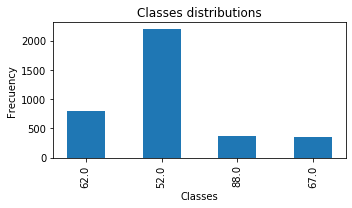

In [10]:
path = "../../../../thesis/work/"

# # features with full data
# features_light_curves = pd.read_csv(path + "features_with_test_10MM")
# features_light_curves = features_light_curves.loc[:, ~features_light_curves.columns.str.contains('^Unnamed')]

# #features with 2 classes
# features_light_curves = pd.read_csv(path + "features_with_28624_objects_and_2_classes_and_63_features_20191213-135652.csv")

#features with 4 classes
features_light_curves = pd.read_csv(path + "features_with_3726_objects_and_4_classes_and_63_features_20191213-143431.csv")

# define number of classes
n_classes = features_light_curves.target.unique().shape[0]

# print shape
print("There are " + str(features_light_curves.shape[0]) + " differentes objects, classified in "+ str(n_classes) + " differentes classes")

# display data
display(features_light_curves.head())

# describe data
display(features_light_curves.describe())

fig, ax = plt.subplots(figsize = (5, 3), tight_layout = True)
ax.bar([str(x) for x in features_light_curves.target.unique()], features_light_curves.groupby("target").count().Amplitude.values, width = 0.5, align = "center")
# ax[1].hist(merged_data_test1_filter.true_target, bins = 14)
ax.set_xlabel("Classes")
ax.set_ylabel("Frecuency")
ax.set_title("Classes distributions")
# ax[1].hist(merged_data_test.loc[:, "target"])
plt.xticks(rotation=90)


Para validar correctitud de dataset, se presenta histograma de las clases (se debe mantener ya que únicamente se cambian las features, no se cambian los objetos ni las clases).

# Dimensionality reduction PCA

Se aplica PCA para obtención de variables latentes. Se estandarizan las variables.

In [11]:
# Standarizing data
from sklearn.preprocessing import StandardScaler

# Standarize data
# this does not consider the last column (it's the target)
std_features_light_curves = StandardScaler().fit_transform(features_light_curves.iloc[:, 0: len(features_names)])

# print(std_features_light_curves.shape)
# print(len(features_names))
# plot standardized 
if len(features_light_curves.columns) < 3:
    
    fig, ax = plt.subplots( 1, (len(features_names)), tight_layout = True, figsize = (8, 3))
    for i, f in enumerate(range(0, 4)):
    #     print(i, f)
        ax[i].hist(std_features_light_curves[:, f])
        ax[i].set_title(features_names[f])
        
else:
    
    print("Not ploting features because they are a lot !")

Not ploting features because they are a lot !


Para analisis posterior, se obtienen igual número de PC que número de features obtenidas.

In [12]:
# PCA 
from sklearn.decomposition import PCA

n_latent_variables = features_light_curves.shape[1]-1
pca = PCA(n_components = n_latent_variables)

principalComponents = pca.fit_transform(std_features_light_curves)

# converting to DF
pca_df = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])
                     )
# pca_df["object_id"] = object_ids
pca_df["target"] = features_light_curves["target"].values
pca_df.head()
# fig, ax = plt.subplots()
# ax.hist(features_light_curves.target)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,target
0,-1.133775,1.361758,0.290513,-0.731497,2.181554,-1.157188,-0.238196,-0.394741,0.734141,-0.833169,...,-0.016143,-0.000489,-0.225624,-0.002023,-0.005781,-0.034789,-3.827565e-17,-1.481084e-17,-1.116572e-16,62.0
1,-0.765115,-1.445335,1.261142,-3.057099,-0.698090,0.783651,-1.227471,0.757340,-1.647741,0.826148,...,-0.012234,-0.117009,-0.017119,-0.025928,0.012675,-0.017677,3.262589e-17,-6.621735e-17,-2.516608e-16,62.0
2,-0.713914,-1.603313,0.300756,0.577105,1.317648,0.227777,0.629627,-0.571461,2.420139,-1.089218,...,-0.047348,-0.038568,0.002827,0.183056,0.001788,0.012782,-1.042864e-18,-2.869158e-17,-3.549159e-17,62.0
3,-0.345899,-2.556773,0.509962,-0.837643,-0.372915,0.470375,0.524093,-1.701663,-0.317018,-0.196415,...,-0.044217,0.003659,0.015624,-0.033936,-0.041073,-0.032474,1.298016e-16,-2.506410e-16,-3.170538e-17,62.0
4,-0.814360,0.107456,0.343401,-0.094376,0.023912,-1.750039,1.340865,-0.296108,-0.594669,-0.591263,...,-0.001076,0.020988,0.011407,-0.094370,0.004179,-0.036524,4.035088e-17,-1.015074e-16,-2.990684e-18,62.0


Explained variance with last LT:  0.9999999999999999


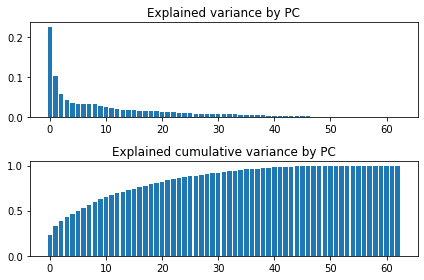

In [13]:
# plotting explained variance
fig, ax = plt.subplots(2, 1, tight_layout = True)
ax[0].bar(np.arange(n_latent_variables), pca.explained_variance_ratio_)
ax[0].set_title("Explained variance by PC")
ax[1].bar(np.arange(n_latent_variables), np.cumsum(pca.explained_variance_ratio_))
ax[1].set_title("Explained cumulative variance by PC")
print("Explained variance with last LT: ", np.cumsum(pca.explained_variance_ratio_)[-1])

Se observa como cada PC aumenta el porcentaje de varianza explicada de los datos originales.

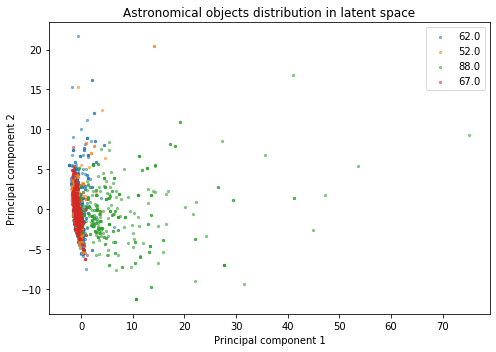

In [14]:
# plotting data projection with PCA
fig, ax  = plt.subplots(figsize = (7,5), tight_layout = True)
for label in pca_df.target.unique():
    
    ax.scatter(pca_df.loc[pca_df.target == label, 0], pca_df.loc[pca_df.target == label, 1], s=5, alpha=0.5, cmap=plt.cm.tab10, label=str(label))
#     ax.scatter(pca_df.iloc[:, 4], pca_df.iloc[:, 5], s=5, alpha=0.5, cmap=plt.cm.tab10, label=str(label))
    ax.set_xlabel("Principal component 1")
    ax.set_ylabel("Principal component 2")
    ax.set_title("Astronomical objects distribution in latent space")
plt.legend()
# for i, txt in enumerate(pca_df["label"]):
# #     print(txt)
#     ax.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i,1]))
    

Para efectos puramente de visualización, se tiene gráfico de data en función PC 1 y 2. Cabe destacar que la clase 88 se separa notoriamente respecto a las demás clases (se desconoce causa). Se podría realizar analisis de clustering y buscar razón de separación.

# Dimensionality reduction with Autoencoder

Se aplica Autoencoder para encontrar variables latentes mediante redes neuronales. Se utiliza pytorch y CUDA para entrenamiento.

## Format data to train autoencoder

Se construye dataloader para entrenamiento y testing. Para entrenamiento se utilizan minibatches.

In [15]:
import torch
from torch.utils import data

# model = AutoEncoder(latent_dim = 1)

# Create dataset
# print("Data shape: ", torch_data.shape)
torch_data = torch.from_numpy(std_features_light_curves).float()
torch_targets = torch.tensor(features_light_curves.iloc[:, -1].values).float()

dataset = data.TensorDataset(torch_data,torch_targets) # create your datset
# train_loader = data.DataLoader(dataset, batch_size=256) # create your dataloader

# Split train/test data
train_size = int(0.8 * std_features_light_curves.shape[0])
test_size = std_features_light_curves.shape[0] - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# train loader
train_loader = data.DataLoader(train_dataset, batch_size=256)
# test loader
test_loader = data.DataLoader(test_dataset)

## Define autoencoder structure

Se itera variaces veces la estructura del AE (Autoencoder), analizando clasificación obtenida (última etapa de este análisis). En este código se deja la que mejor resultado obtuvo.

Estructura de AE:

- Encoder y Decoder: 
    - 2 capas ocultas (fully connected)
    - Función de activación en cada capa oculta (softplus)
    - Codificaicón (capa de salida encoder), se considera una fully connected.
    - Decodificación (capa de salida decoder), se considera una fully connected.

In [16]:
import torch

# Building autoencoder
class Encoder(torch.nn.Module):
    
    def __init__(self, latent_dim, hidden_dim, input_dim = len(features_names)):

        super(Encoder, self).__init__()
        self.hidden_1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_2 = torch.nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_3 = torch.nn.Linear(hidden_dim, hidden_dim) # this does not improve class metrics
        self.code = torch.nn.Linear(hidden_dim, latent_dim)
        self.activation = torch.nn.Softplus()

    def forward(self, x):
        
        output = self.activation(self.hidden_1(x))
        output = self.activation(self.hidden_2(output))
#         output = self.activation(self.hidden_3(output))
        
        return (self.code(output))

class Decoder(torch.nn.Module):
    
    def __init__(self, latent_dim, hidden_dim, output_dim = len(features_names)):
        super(Decoder, self).__init__()
        self.hidden_1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.hidden_2 = torch.nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.decode = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = torch.nn.Softplus()
        
    def forward(self, z):
#         print("Decoder")
        output = self.activation(self.hidden_1(z))
        output = self.activation(self.hidden_2(output))
#         output = self.activation(self.hidden_3(output))
#         output = self.activation(self.hidden_2(output))
#         output = self.activation(self.hidden_2(output))
#         output = self.activation(self.hidden_2(output))
#         output = self.activation(self.hidden_2(output))
        
        return (self.decode(output))
        
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, hidden_dim)
        
    def forward(self, x):
        
        return self.decoder(self.encoder(x))

De todas las estructuras analizadas, se tiene que las que se observan en el código, fueron las que mejores resultados obtuvieron.

Adicionalmente, se definian los valores de dimension latente y hidden limitados por el número de datos que se tienen (el número de parámetros no debe ser mayor al número de observaciones).

In [34]:
# check number of parameters
latent_dim_ae = 63
# latent_dim_ae = 40 # it works fine
# hidden_dim = 10
# hidden_dim = 15 # it was ok
hidden_dim = 12
model = AutoEncoder(latent_dim = latent_dim_ae, hidden_dim = hidden_dim)

# count amount of parameters
pp=0 
for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
        
print("AE parameters: ", pp)
print("Data shape: ", torch_data.shape[0])

AE parameters:  3486
Data shape:  3726


## Train autoencoder

Para entrenamiento se destaca:
- Función de pérdida MSE (Error cuadrático medio).
- 1.000 epocas de entrenamiento.
- Early stopping con 4 epocas como límite (si supera 4 epocas en las que el error sobre el test data es mayor que el anterior, entonces se detiene entrenamiento, ya que modelo se podría estar sobreajustando a data).
- Entrenamiento con CUDA.

early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  3
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  3
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
e

early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  3
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
e

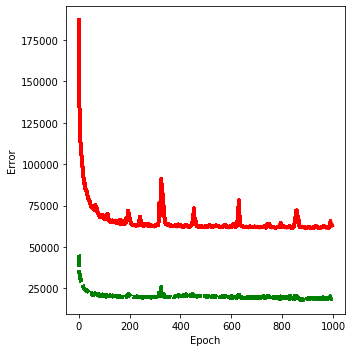

In [35]:
from tqdm import tqdm_notebook
import time

# model = AutoEncoder(latent_dim = n_latent_variables, hidden_dim = 5)
model = AutoEncoder(latent_dim = latent_dim_ae, hidden_dim = hidden_dim)

# model = AutoEncoder(latent_dim = 10, hidden_dim = 5)

# criterion = torch.nn.BCEWithLogitsLoss(reduction='sum') # the target (reconstruction has to be between 0 and 1)
criterion = torch.nn.MSELoss(reduction = "sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

use_gpu = True

if use_gpu:
    model = model.cuda()
# fig, ax = plt.subplots()

# number of epochs
epochs = 1000

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# loss plot
fig, ax = plt.subplots(figsize = (5, 5), tight_layout = True)
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
# plt.legend()
# fig.show()
# fig.canvas.draw()

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 4

for nepoch in tqdm_notebook(range(epochs)):
    
#     print(nepoch)
    
    # train
    epoch_train_loss = 0
    for data, label in train_loader:
        
        optimizer.zero_grad()
        
        if use_gpu:
            
            data = data.type(torch.FloatTensor).cuda()
        else:
            data = data.type(torch.FloatTensor)
            
        outputs = model.forward(data.type(torch.FloatTensor).cuda())
        
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
#     print("Train epoch {0} loss: {1}".format(nepoch, epoch_train_loss))
    train_loss[nepoch] = epoch_train_loss
    
    # test
    epoch_test_loss = 0
    
    for data, label in test_loader:
        
        if use_gpu:
            
            data = data.type(torch.FloatTensor).cuda()
        else:
            data = data.type(torch.FloatTensor)
            
        outputs = model.forward(data)
        
        loss = criterion(outputs, data)
        
        epoch_test_loss += loss.item()
    
#     print("Test epoch {0} loss: {1}".format(nepoch, epoch_test_loss))
    test_loss[nepoch] = epoch_test_loss
    
    # plot loss
    ax.plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
    ax.plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green") 
#     plt.show()
#     fig.canvas.draw()
#     plt.legend()
#     time.sleep(1)
#     plt.show
#     plt.pause(1)
    fig.canvas.draw()
    
    # Early stopping
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
#     if count_early_stop > 3:
#         print("early stopping counter: ", count_early_stop)
        
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        break   

In [36]:
if use_gpu:
    model = model.cpu()

## Save model

Debido a que modelo tardaban bastante tiempo en entrenar (un modelo llegó a tardar 9 horas (sin CUDA, por lo que debí instalarlo)), se almacenaban luego de entrenamiento.

In [71]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

model_path = "./model_latent_" + str(latent_dim_ae) + "_hidden_" + str(hidden_dim) + "_epochs_" + str(epochs) + "_time_" + timestr + ".pt"

torch.save(model.state_dict(), model_path)

## Latent representation

Teniendo el modelo entrenado, se puede utilizar el encoder para obtener variables latentes. Se ingresa al modelo la data bruta (cada objeto astrónomico diferentes con sus valores de features), y se obtienen variables latentes. Se crea dataframe a partir de esta data.

(3726, 63)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,target
0,0.035660,0.013241,-1.995802,0.046977,0.002314,0.516119,-0.082458,-0.005550,0.050775,-0.019189,...,-0.021194,-0.146933,0.034233,-0.146205,0.210345,-0.237897,-0.012949,0.013714,0.359026,62.0
1,0.000671,-0.074200,-2.089737,0.224303,0.015143,-1.151924,-0.368542,-0.009083,-0.061592,-0.054712,...,0.047271,-0.125939,-0.201353,0.791460,-0.473921,-0.813559,-0.014041,0.017428,0.186450,62.0
2,-0.020328,-0.001715,-1.175219,-0.041337,0.024058,-0.032721,0.061118,-0.023876,0.011779,0.010151,...,0.009826,0.113979,-0.001675,0.076612,-0.123356,-0.520065,0.023641,0.031608,-0.309499,62.0
3,-0.043190,0.044724,-1.236828,-0.008917,0.055419,-0.686367,0.009294,-0.092260,0.072693,0.059540,...,-0.034743,0.024864,-0.167592,0.131550,-0.353212,-0.813452,0.066231,0.089029,-0.356777,62.0
4,0.055105,0.071286,-1.484651,-0.090033,-0.017294,0.268454,0.195033,0.003983,0.092585,-0.042031,...,-0.058731,0.012614,0.056699,-0.367345,0.085886,-0.189594,-0.003573,0.009993,0.074679,62.0


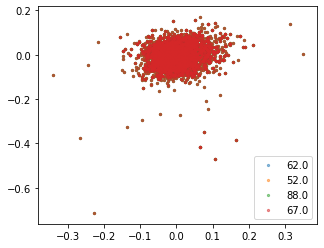

In [37]:
# get latent representation of data
latent_representation = model.encoder(torch_data.type(torch.FloatTensor)).detach().numpy()

print(latent_representation.shape)
# Creating new DF
autoencoder_df = pd.DataFrame(data = latent_representation
#              , columns = ['lv 1', 'lv 2'])
                             )

# autoencoder_df["object_id"] = object_ids
autoencoder_df["target"] = features_light_curves["target"].values
display(autoencoder_df.head())

# plotting latent representation
fig, ax  = plt.subplots(figsize = (5,4))
for label in autoencoder_df.target.unique():
    ax.scatter(autoencoder_df.iloc[:, 0], autoencoder_df.iloc[:, 1], s=5, alpha=0.5, cmap=plt.cm.tab10, label=str(label))    
plt.legend()
# for i, txt in enumerate(pca_df["label"]):
# #     print(txt)
#     ax.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i,1]))

Solo para visualización, se grafica dataset en representación de 2 variables latentes. Cabe destacar que acá, las variables latentes no estan ordenadas por varianza explicada (como el caso de PCA). Probablemente sea la razón por la cual no se observa separación de clases.

## Save latent data 

In [36]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

path = "./latent_ae_dataset_lv_" + str(latent_dim_ae) + "_hidden_" + str(hidden_dim) + "_epochs_" + str(epochs) + "_time_" + timestr + ".csv"
# store dataframe
autoencoder_df.to_csv(index=False, path_or_buf = path)

# Supervised classification

Para analizar si variables latentes generadas son útiles, se utilizan como entrada para entrenear un clasificador (regresor logístico en este caso). El regresor se entrena considerando las variables latentes (PCA y AE) como entrada, y la etiqueta como objetivo.

Para el entrenamiento, se separa la data en entrenamiento y testing.

In [38]:
# Split data in train and testing
from sklearn.model_selection import train_test_split

# split data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(pca_df.iloc[:, 0:(pca_df.columns.shape[0] - 1)] , pca_df["target"], test_size=0.4, random_state=0)
X_ae_train, X_ae_test, y_ae_train, y_ae_test = train_test_split(autoencoder_df.iloc[:, 0:(autoencoder_df.columns.shape[0] - 1)] , autoencoder_df["target"], test_size=0.4, random_state=0)

print("train PCA: ", X_pca_train.shape)
print("test PCA: ", X_pca_test.shape)

print("train AU: ", X_ae_train.shape)
print("test AU: ", X_ae_test.shape)

train PCA:  (2235, 63)
test PCA:  (1491, 63)
train AU:  (2235, 63)
test AU:  (1491, 63)


Para analizar el efecto del número de variables latentes sobre la clasificaición, se entrena un regresor logístico para cada subconjunto de variables latentes. Luego, se obtiene accuracy y F1 score sobre el conjunto de testing.

In [39]:
# Train LR
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# score variable
n_metrics = 2
scores_PCA = np.zeros((n_latent_variables, n_metrics))
scores_AE = np.zeros((latent_dim_ae, n_metrics))

print("PCA LR training")
# f1_score_to_0 = 0

# train LR with differentes number of PCs (PCA)
for i in tqdm_notebook(range(1, n_latent_variables + 1)):

    #     display(X_pca_train.iloc[:, 0:i].head())
    
    # training with PCA
    clf_pca = LogisticRegression(max_iter = 10000, multi_class = "auto", solver = "lbfgs", random_state=0).fit(X_pca_train.iloc[:, 0:i], y_pca_train)
#     print(clf_pca.predict(X_pca_train.iloc[:, 0:i]).shape)
    score_pca_acc = clf_pca.score(X_pca_test.iloc[:, 0:i], y_pca_test)
    predictions = clf_pca.predict(X_pca_test.iloc[:, 0:i]).astype("int")
    
    score_pca_f1 = f1_score(y_pca_test.astype("int"), predictions, average = "weighted")
    
#     # some predictions only predicts for a minur number of classes
#     if predictions.shape[0] == n_classes:
    
#         score_pca_f1 = f1_score(y_pca_test.astype("int"), predictions, average = "weighted")
        
#     else:
#         score_pca_f1 = -1
#         f1_score_to_0 += 1
        
    scores_PCA[i-1, 0] = score_pca_acc
    scores_PCA[i-1, 1] = score_pca_f1
    

# print("f1 score to -1 (not all classes were predicted and it's fill with 0): ", f1_score_to_0)

print("AE LR training")
# f1_score_to_0 = 0
# train LR with differentes number of LV (AE)
for i in tqdm_notebook(range(1, latent_dim_ae + 1)):

    # trainig with AE
    clf_ae = LogisticRegression(max_iter = 10000, multi_class = "auto", solver = "lbfgs", random_state=0).fit(X_ae_train.iloc[:, 0:i], y_ae_train)
    score_ae_acc = clf_ae.score(X_ae_test.iloc[:, 0:i], y_ae_test)
    
    predictions = clf_ae.predict(X_ae_test.iloc[:, 0:i]).astype("int")
    
    score_ae_f1 = f1_score(y_ae_test.astype("int"), clf_ae.predict(X_pca_test.iloc[:, 0:i]).astype("int"), average = "weighted")
    
#     # some predictions only predicts for a minur number of classes
#     if predictions.shape[0] == n_classes:
        
#         score_ae_f1 = f1_score(y_ae_test.astype("int"), clf_ae.predict(X_pca_test.iloc[:, 0:i]).astype("int"), average = "weighted")
        
#     else:
        
# #         print("f1 score to -1 (not all classes were predicted and it's fill with 0)")
#         score_ae_f1 = -1
#         f1_score_to_0 += 1
        
#     score_ae = f1_score(y_ae_test, X_ae_test.iloc[:, 0:i], average='macro')
#     print("Score with PCA: ", score)
    scores_AE[i-1, 0] = score_ae_acc
    scores_AE[i-1, 1] = score_ae_f1

# print("f1 score to -1 (not all classes were predicted and it's fill with 0): ", f1_score_to_0)
# # plot scores
# fig, ax = plt.subplots()
# ax.scatter(range(1, n_latent_variables), scores_PCA)
# # scores_PCA

PCA LR training


/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave


AE LR training


/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


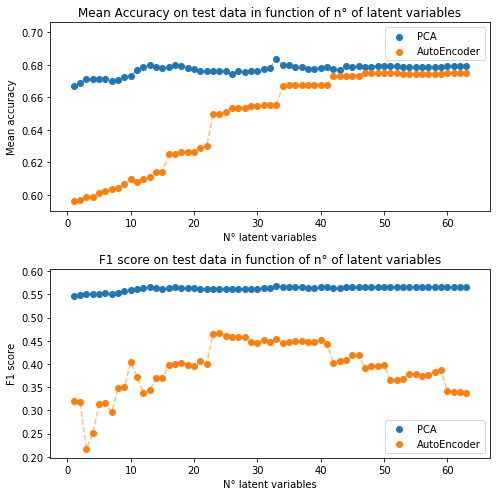

In [40]:
# scores_PCA.shape
# np.arange(1, n_latent_variables+1)
# plot scores
fig, ax = plt.subplots(2, 1, figsize = (7, 7), tight_layout = True)

# accuracy

# PCA
ax[0].scatter(np.arange(1, n_latent_variables+1), scores_PCA[:, 0], label = "PCA")
ax[0].plot(np.arange(1, n_latent_variables+1), scores_PCA[:, 0], linestyle = "--", alpha = 0.5)
ax[0].set_xlabel("N° latent variables")
ax[0].set_ylabel("Mean accuracy")
ax[0].set_title("Mean Accuracy on test data in function of n° of latent variables")

# AE
ax[0].scatter(np.arange(1, latent_dim_ae+1), scores_AE[:, 0], label = "AutoEncoder")
ax[0].plot(np.arange(1, latent_dim_ae+1), scores_AE[:, 0], linestyle = "--", alpha = 0.5)

ax[0].legend()

# f1 score

# PCA
ax[1].scatter(np.arange(1, n_latent_variables+1), scores_PCA[:, 1], label = "PCA")
ax[1].plot(np.arange(1, n_latent_variables+1), scores_PCA[:, 1], linestyle = "--", alpha = 0.5)
ax[1].set_xlabel("N° latent variables")
ax[1].set_ylabel("F1 score")
ax[1].set_title("F1 score on test data in function of n° of latent variables")

# AE
ax[1].scatter(np.arange(1, latent_dim_ae+1), scores_AE[:, 1], label = "AutoEncoder")
ax[1].plot(np.arange(1, latent_dim_ae+1), scores_AE[:, 1], linestyle = "--", alpha = 0.5)

ax[1].legend()


Desde los gráficos se observa:

- Para el caso de accuracy, PCA obtiene mayor valor que AE, para todos los números de variables latentes, por lo que en este caso, PCA obtendría mejores resutlados en clasificación supervisada.
- Para el caso de PCA, el mejor valor de accuracy, se obtiene para 33 variables latentes.
- Para el AE, el mejor valor de accuracy, se obtiene para 50 variables latentes.
- Para PCA, se observa que accuracy se mantiene semi-constante para los diferentes números de variables latentes, implicando que el número de variables latentes podría no influir tanto en el valor de accuracy.
- Para el caso de AE, se tiene que a mayor número de variables latentes, se tiene mayor valor de accuracy, lo que sugiere que el número de variables influye en el accuracy. Sin embargo,  desde 43 variables lantes hasta la última, el valor de accuracy se mantiene constante.
- Para el caso de F1 score, se tiene que PCA mantiene valor superior que AE.
- Para PCA, F1 score se mantiene constante respecto a n° var. latentes, lo que implica que esto no influye en el valor de accuracy.
- Para el caso de AE, el valor de F1 score, varía en función del n° var. latentes, incluso, se observa que se tiene aumento de accuracy, luego se mantiene constante, y luego vuelve a disminiuir, sugiriendo que el número de variables latentes que mejor valor de F1 score, corresponden a las del sector medio (de 23 a 43).

### Save scores

In [77]:
# Save scores
from numpy import savetxt
import time

timestr = time.strftime("%Y%m%d-%H%M%S")

# path
path = "./scores_pca_with_lv_" + str(n_latent_variables) + "_hidden_" + str(hidden_dim) + "_epochs_" + str(epochs) + "_time_" + timestr + ".csv"
# store dataframe
savetxt(path, scores_PCA, delimiter=';')

# path
path = "./scores_ae_with_lv_" + str(latent_dim_ae) + "_hidden_" + str(hidden_dim) + "_epochs_" + str(epochs) + "_time_" + timestr + ".csv"
# store dataframe
savetxt(path, scores_PCA, delimiter=';')

## Principales conclusiones
- Se logra obtener features sobre curvas de luz analizadas, comprobando que el tiempo de cálculo es extenso. Muchas de ellas requieren calculos complejos, tales como transformada de fourier.
- Se obtienen variables latentes utilizando PCA. Se observan como explican la varianza de la data original. 
- Se obtienen variables latentes utilizando AE. 
- Se obtiene mayores valores de accuracy utilizando variables latentes obtenidas con PCA.
- La relación entre accuracy y n° variables lantetes para PCA, es muy baja, por lo que el n° de var. no influye considerablmente en el valor de accuracy.
- Existe relación entre accuracy y el número de variables latentes para el caso de AE.
- Se obtienen mayores valores de F1 score para PCA.
- No existe mayor correlación entre n° var. y F1 score para el caso de PCA.
- Existe correlación entre n° de var. y F1 score para el caso de AE.
- Si bien, se analizan diferentes arquitecturas del AE, se pueden seguir analizando mas, las que pueden llegar a obtener mejores métricas que el modelo propuesto.